**Welcome to the Third programming assignment for CS 443 RL!**

This assignment will have you implementing tabular model-free value-based method (temporal difference learning) and Q-learning with function approximation.


**Part 1 (5pts)**

In part 1, you will implement the tabular model-free value-based method (temporal difference learning). It is a follow-up task of the last assignment. The environment is the same taxi environment.

In [ ]:
import gym
import numpy as np
print(gym.__version__)

0.25.2


We will be playing on the
Taxi environment in this part. The environment is loaded as follows:

In [ ]:
taxi_env = gym.make('Taxi-v3')
starting_state = taxi_env.reset() #must reset the environment before interacting with it

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


The Taxi domain was introduced in the paper "The MAXQ Method for Hierarchical Reinforcement Learning" by Thomas G. Dietterich (https://pdfs.semanticscholar.org/fdc7/c1e10d935e4b648a32938f13368906864ab3.pdf) in ICML 1998.

The version that we will be playing is slightly simpler than the version considered in that paper. Here is a description from the open source code for gym:

> Description:
    There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger's location, picks up the passenger, drives to the passenger's destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.

> Observations:
    There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations.

    
    Passenger locations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    - 4: in taxi

    Destinations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)

    Actions:
    There are 6 discrete deterministic actions:
    - 0: move south
    - 1: move north
    - 2: move east
    - 3: move west
    - 4: pickup passenger
    - 5: drop off passenger

    Rewards:
    There is a default per-step reward of -1,
    except for delivering the passenger, which is +20,
    or executing "pickup" and "drop-off" actions illegally, which is -10.

    Rendering:
    - blue: passenger
    - magenta: destination
    - yellow: empty taxi
    - green: full taxi
    - other letters (R, G, Y and B): locations for passengers and destinations
    
    state space is represented by:
        (taxi_row, taxi_col, passenger_location, destination)

Same as the last assignment, we add a terminal state (the taxi drops off the passenger at the destination) in the MDP. So we end up with 501 states in total. We provide you with an MDP class for modelling the environment and you can directly use it.

In [ ]:
class MDP:
  def __init__(self,env):
    self.num_states = env.observation_space.n + 1
    self.num_actions = env.action_space.n
    self.starting_state = starting_state
    self.action_to_plot = 1

    self.R = np.zeros([self.num_states, self.num_actions])
    self.T = np.zeros([self.num_states, self.num_actions, self.num_states])
    self.gamma = 0.99

    for state in range(self.num_states - 1):
      for action in range(self.num_actions):
          for transition in env.env.P[state][action]:
              probability, next_state, reward, done = transition
              self.R[state, action] = reward
              self.T[state, action, next_state] = probability

    for action in range(self.num_actions):
      self.T[-1, action, -1] = 1

    for state in range(self.num_states - 1):
      state_decode = list(env.env.decode(state))
      des_x = taxi_env.env.locs[state_decode[3]][0]
      des_y = taxi_env.env.locs[state_decode[3]][1]
      if (state_decode[2] == 4) and (state_decode[0] == des_x) and (state_decode[1] == des_y):
        self.T[state, 5] = 0
        self.T[state, 5, -1] = 1

  def reset(self):
    env.reset()

The MDP for Taxi is created as follows:

In [ ]:
taxi_env.reset()
taxi_mdp = MDP(taxi_env)
#attributes of the MDP:
print(taxi_mdp.num_states) #number of states
print(taxi_mdp.num_actions) #number of actions
print(taxi_mdp.gamma) #gamma
print(taxi_mdp.R.shape) #reward matrix (dimension num_states X num_actions)
print(taxi_mdp.T.shape) #transition matrix (dimension num_states x num_actions X num_states)


501
6
0.99
(501, 6)
(501, 6, 501)


***Q1: Implement Temporal-Difference Learning TD($0$) to estimate the value function of a policy $\pi$***

Write a method called <code>td(mdp,policy,env)</code> which takes a (taxi) MDP, a policy $\pi$, and the (taxi) environment as input and estimates the value function $V^\pi$ of that input policy using the TD($0$) algorithm. You should implement it by following trajectories $(s_0,a_0,r_0,s_1,a_1,...s_T,a_T,r_T)$ generated by the policy interacting with the environment. After each episode you should reset the environment with env.reset(), which is why the environment is input as an argument. You must also choose an appropriate step-size (learning rate).

Run your code with uniformly random policy <code>policy_unif</code>, which we have instantiated below, and plot a 'learning curve' for the value of the starting state at each episode, where the iteration number is on the $x$-axis and the V(starting_state) is on the $y$-axis. As a stopping criterion, you can use a maximum number of episodes of 5000. You can also return other values needed for your plot (e.g. training values) as long as you return the final value_fn.

You code might run for a couple of minutes. For a sanity check, you should expect the result of TD($0$) to have similar (but possibly different) magnitude as the result of policy evaluation (Q2 in the last assignment) in the starting state. Note that one difference between the two functions is that we obtain a state-value function from TD($0$), but obtained a Q-value function from policy evaluation in Q2. An additional conversion step is needed in order to directly compare the results.

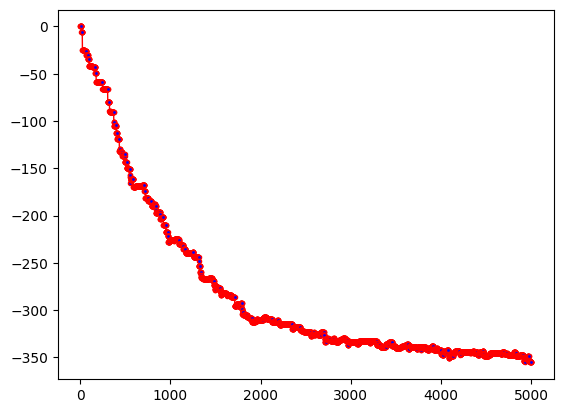

In [ ]:
def td(mdp, policy, env):
  value_fn = np.zeros([mdp.num_states])
  #YOUR CODE HERE
  #You will need to follow a trajectory (s_0,a_0,r_0,s_1,a_1,r_1,...s_T,a_T,r_T) by sampling actions from the policy and states/rewards from the environment.
  #Use env.step(action) to take a step in the environment. Recall that env.step outputs are of the form (next state, reward, done, info).
  #Reset the environment once you reach a terminal state

  ## record learning plot
  V_plot = []
  V_plot.append(0)

  ## hyperparameters and init
  episodes = 5000
  alpha = 0.2
  state = mdp.starting_state

  ## create for sampling action
  policy_use = np.zeros(policy.shape)
  for s in range(mdp.num_states):
    policy_use[s][0] = policy[s][0]
    for idx in range(np.shape(policy[s])[0] - 1):
      policy_use[s][idx + 1] = policy[s][idx + 1] + policy_use[s][idx]

  for episode in range(episodes):
    done = False
    state = env.reset()
    while not done:
      ## sampling next action
      sample = np.random.rand(1)
      choice = np.where(policy_use[state] >= sample)
      action = choice[0][0]

      ## move forward in sample trajectory
      next_state, reward, done, info = env.step(action)
      value_fn[state] += alpha * (reward + mdp.gamma * value_fn[next_state] - value_fn[state])

      ## move to next state
      state = next_state

    ## finish one episode
    V_plot.append(value_fn[mdp.starting_state])

  return value_fn, V_plot

#run your code on the uniform policy
policy_unif = 1./taxi_mdp.num_actions * np.ones([taxi_mdp.num_states,taxi_mdp.num_actions])

taxi_env.reset()
taxi_mdp = MDP(taxi_env)
value_fn, V_plot = td(taxi_mdp, policy_unif, taxi_env)

## plot result
import matplotlib.pyplot as plt

x = []
for i in range(len(V_plot)):
  x.append(i)

plt.figure()
plt.plot(x, V_plot, linewidth=1, color='r', marker='o', markerfacecolor='blue', markersize=3)
plt.show()

**Part 2 (7pts)**

This question will get you familiar with value function approximation and Q-learning. You need to write your code from scratch and explore the good hyperparameters. The question is inspired/borrowed from Philip Thomas's course.

You only need to report your result for one trial/run. There is some randomness in the environment, so you don't need the result of every trial to meet the expectation. But make sure that, in general, you can get similar (high return) results with the same hyperparameters. For grading, we will not only look at your figure, but may also run your code and see whether we can reproduce similar (high return) results. That said, we may later request your notebook file if needed, though you don't need to submit them now. You will receive partial credit if your result is mostly due to randomness. We may also use our hyperparameters to test your code. If your result does not meet the expectation because of the hyperparameters but your implementation is correct, you will receive partial credit.

Make sure your submitted version contain the final results (figures). If not, you will only get partial credit.

In [ ]:
import gym
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

We will be playing on the Cartpole environment. As the title suggests, the task in this environment is to balance a pole on top of a cart. The official description of the environment from the OpenAI Gym website (https://gym.openai.com/) is:

> A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center. CartPole-v1 defines "solving" as getting average reward of 475.0 over 500 consecutive trials. This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson [Barto83].

In the environment, the actions are dicrete and indexed as 0, 1. The state space is a 4 dimension continuous space. In all the following, the trajectory is $\tau=(s_0,a_0,r_0,s_1,a_1,r_1,\dots,s_T,a_T,r_T)$.

More information can be found on the following wiki page: https://gym.openai.com/envs/CartPole-v1/

**Q2: Implement the Q-leraning algorithm using the Fourier basis as linear approximation component**.

Write a method called <code>q_learning(gamma, epsilon, alpha, n, num_epi)</code>, which implements Q-learning with $\epsilon$-greedy action selection, discount factor $\gamma$, learning rate $\alpha$, and runs for num_epi episodes. $n$ is the order of Fourier basis.

The update of Q-learning with linear function approximation is
$$\delta_t = r_t + \gamma \max_a w^\top \phi(s_{t+1},a)-w^\top \phi(s_t,a_t)$$
$$w_{t+1}=w_t+\alpha\delta_t \phi(s_t,a_t),$$
where $\phi(s_t,a_t)$ is the feature and $w_t$ is the weight; together, $w^\top \phi(s_t,a_t)$ forms a linear approximation of the Q-value $Q(s_t,a_t)$. The initial weights are set to 0. If $s_{t+1}$ is a terminal state, set its value to 0, i.e., $w^\top \phi(s_{t+1},a)=0$. In the implementation, you may just replace $w^\top \phi(s_{t+1},a)$ with 0.

Since the Cartpole environment has a discrete action space but continuous state space, we ask you to apply linear approximation with a Fourier basis on the state space (Equation (4) in http://psthomas.com/papers/Konidaris2011a.pdf), and tabular representation for the action space. Specifically, let $\phi(s,a)$ be the same for all actions, i.e. $\forall a, \phi(s,a)=\psi(s)$, where $\psi(s)$ is constructed according to Equation (4):
$$\psi(s) = \cos(\pi \mathbf{c} \cdot s)$$
Since actions are respresented in a tabular manner, different actions $a$ should have different weight vectors, with length equal to the length of $\psi(s)$. For ease of implementation, we have provided you with a function <code>state_action_feature</code> which takes the Fourier basis order $n$ as input, and outputs the vector $\mathbf{c}$ (used to compute $\psi(s)$ as per Equation (4)), plus initialized weights $w$ of the correct dimension for the Q-function. You should also use the same learning rate $\alpha$ for all the features (they don't need to be scaled according to the paper).
  
<!-- Specifically, construct $\psi(s)$ according to the reference and let $\phi(s,a)$ be the same for all actions, i.e. $\forall a, \phi(s,a)=\psi(s)$. Then, use different weight vectors for different actions $a$ (the length of one weight vector is the same as the number of features for $\psi(s)$).  -->


Your <code>q_learning</code> function should return a list (with length <code>num_epi</code>), which consists of the smoothed undiscounted return. That's said, first calculate the undiscounted return of the current episode without discount factor $\gamma$. Then calculate the mean of undiscounted return for last 200 episodes. If there are less than 200 episodes, calculate the mean of all episodes. Notice that you may use $\gamma<1$ in your algorithm, but you need to calculate the undiscounted return.

After tuning the hyperparameters $\gamma,\epsilon,\alpha$, and $n$, run the <code>q_learning</code> function for 5000 episodes and draw a figure of the smoothed undisounted return obtained from the <code>q_learning</code> function. The $x$-axis is the number of episodes (5000 in total) and the $y$-axis is the smoothed undisounted return.

You can use any reasonable hyperparameters, but you should expect the smoothed undisounted return to exceed 150, though it may not increase monotonically. If running 5000 episodes takes too long and your result exceeds 150 for many (e.g. 500) episodes, you may also report your final result with fewer episodes.

<ipython-input-41-fde7ce2aa344>:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if float(np.random.rand(1)) < epsilon:


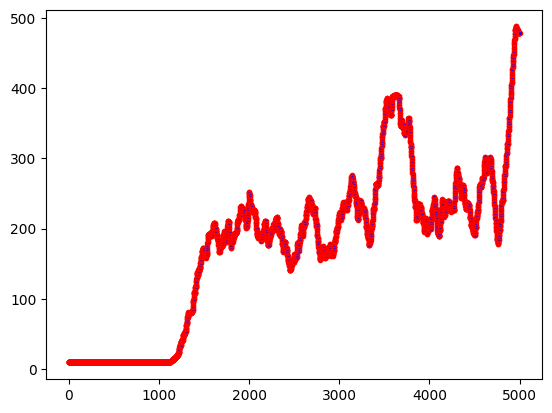

In [ ]:
env = gym.make('CartPole-v1')

# Construct the c vector and weights
def state_action_feature(n):
  dim_state = 4
  num_action = 2
  vec_c = []
  for i in range((n + 1) ** dim_state):
    index = i
    temp_c = []
    for j in range(dim_state):
      temp_c.append(index % (n + 1))
      index //= n + 1
    vec_c .append(temp_c)
  vec_c = np.asarray(vec_c)
  weight = np.zeros(((n+1) ** dim_state, num_action))
  return vec_c, weight

def q_learning(gamma, epsilon, alpha, n, num_epi):
  ### Your code here
  org_returns = []
  smoothed_undiscounted_return_list = []           # smoothed discounted returns

  ## initialize weight
  vec_c, weight = state_action_feature(n)

  for episode in range(num_epi):
    state = env.reset()          # initialize S
    undiscounted_return = 0
    done = False
    while not done:

      ### Action Selection (epsilon greedy) ###

      ## prob epsilon to select randomly
      if float(np.random.rand(1)) < epsilon:
        a_t = int(np.random.randint(low=0, high=2, size=1 ,dtype='int'))
        comp_cur = weight.T[a_t] @ np.cos(np.pi * vec_c @ state.reshape((4, 1)))

      ## otherwise select optimal
      else:
        comp0 = weight.T[0] @ np.cos(np.pi * vec_c @ state.reshape((4, 1)))
        comp1 = weight.T[1] @ np.cos(np.pi * vec_c @ state.reshape((4, 1)))
        if comp0 >= comp1:
          a_t = 0
          comp_cur = comp0
        else:
          a_t = 1
          comp_cur = comp1

      ## take step
      next_state, reward, done, info = env.step(a_t)

      ## find argmax a
      if done:
        comp_next = 0
      else:
        comp0_next = weight.T[0] @ np.cos(np.pi * vec_c @ next_state.reshape((4, 1)))
        comp1_next = weight.T[1] @ np.cos(np.pi * vec_c @ next_state.reshape((4, 1)))
        if comp0_next >= comp1_next:
          comp_next = comp0_next
        else:
          comp_next = comp1_next

      ## compute delta
      delta = reward + gamma * comp_next - comp_cur
      undiscounted_return += reward     # store reward

      ## update W
      weight.T[a_t] += (alpha * delta * np.cos(np.pi * vec_c @ state.reshape((4, 1)))).reshape(weight.T[a_t].shape)

      ## to next stage
      state = next_state

    ## finish one episode
    org_returns.append(undiscounted_return)
    if len(org_returns) <= 200:
      smoothed_undiscounted_return_list.append(sum(org_returns) / len(org_returns))
    else:
      smoothed_undiscounted_return_list.append(sum(org_returns[-201:]) / 200)

  return smoothed_undiscounted_return_list

# Draw the figure with the smoothed undiscounted return list
### Your code here

import matplotlib.pyplot as plt

## hyperparameters
gamma = 0.99        # discount
epsilon = 0.001        # random action selection
alpha = 0.001       # learning rate
n = 5           # Fourier dim
num_epi = 5000

y = q_learning(gamma, epsilon, alpha, n, num_epi)
x = []
for i in range(len(y)):
  x.append(i)

plt.figure()
plt.plot(x, y, linewidth=1, color='r', marker='o', markerfacecolor='blue', markersize=3)
plt.show()

<ipython-input-43-9b59b9fdb2bd>:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if float(np.random.rand(1)) < epsilon:


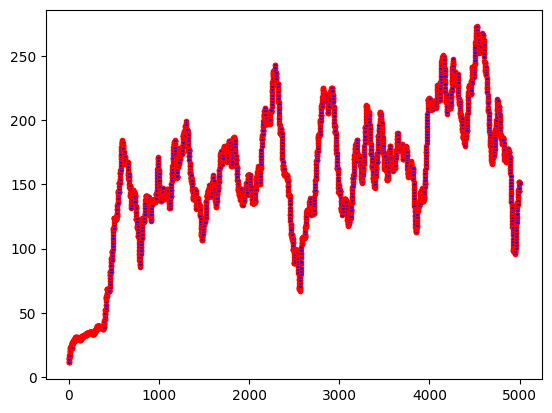

In [ ]:
env = gym.make('CartPole-v1')

# Construct the c vector and weights
def state_action_feature(n):
  dim_state = 4
  num_action = 2
  vec_c = []
  for i in range((n + 1) ** dim_state):
    index = i
    temp_c = []
    for j in range(dim_state):
      temp_c.append(index % (n + 1))
      index //= n + 1
    vec_c .append(temp_c)
  vec_c = np.asarray(vec_c)
  weight = np.zeros(((n+1) ** dim_state, num_action))
  return vec_c, weight

def q_learning(gamma, epsilon, alpha, n, num_epi):
  ### Your code here
  org_returns = []
  smoothed_undiscounted_return_list = []           # smoothed discounted returns

  ## initialize weight
  vec_c, weight = state_action_feature(n)

  for episode in range(num_epi):
    state = env.reset()          # initialize S
    undiscounted_return = 0
    done = False
    while not done:

      ### Action Selection (epsilon greedy) ###

      ## prob epsilon to select randomly
      if float(np.random.rand(1)) < epsilon:
        a_t = int(np.random.randint(low=0, high=2, size=1 ,dtype='int'))
        comp_cur = weight.T[a_t] @ np.cos(np.pi * vec_c @ state.reshape((4, 1)))

      ## otherwise select optimal
      else:
        comp0 = weight.T[0] @ np.cos(np.pi * vec_c @ state.reshape((4, 1)))
        comp1 = weight.T[1] @ np.cos(np.pi * vec_c @ state.reshape((4, 1)))
        if comp0 >= comp1:
          a_t = 0
          comp_cur = comp0
        else:
          a_t = 1
          comp_cur = comp1

      ## take step
      next_state, reward, done, info = env.step(a_t)

      ## find argmax a
      if done:
        comp_next = 0
      else:
        comp0_next = weight.T[0] @ np.cos(np.pi * vec_c @ next_state.reshape((4, 1)))
        comp1_next = weight.T[1] @ np.cos(np.pi * vec_c @ next_state.reshape((4, 1)))
        if comp0_next >= comp1_next:
          comp_next = comp0_next
        else:
          comp_next = comp1_next

      ## compute delta
      delta = reward + gamma * comp_next - comp_cur
      undiscounted_return += reward     # store reward

      ## update W
      weight.T[a_t] += (alpha * delta * np.cos(np.pi * vec_c @ state.reshape((4, 1)))).reshape(weight.T[a_t].shape)

      ## to next stage
      state = next_state

    ## finish one episode
    org_returns.append(undiscounted_return)
    if len(org_returns) <= 200:
      smoothed_undiscounted_return_list.append(sum(org_returns) / len(org_returns))
    else:
      smoothed_undiscounted_return_list.append(sum(org_returns[-201:]) / 200)

  return smoothed_undiscounted_return_list

# Draw the figure with the smoothed undiscounted return list
### Your code here

import matplotlib.pyplot as plt

## hyperparameters
gamma = 0.99        # discount
epsilon = 0.1        # random action selection
alpha = 0.001       # learning rate
n = 5           # Fourier dim
num_epi = 5000

y = q_learning(gamma, epsilon, alpha, n, num_epi)
x = []
for i in range(len(y)):
  x.append(i)

plt.figure()
plt.plot(x, y, linewidth=1, color='r', marker='o', markerfacecolor='blue', markersize=3)
plt.show()

**Instructions on converting iPython notebook to pdf**

Please do not directly print the iPython notebook to pdf because it may have some issue if your code or text are too long. The following are two recommended ways. Also feel free to use other methods as long as the converted file visually looks good.

Option 1: if you run the code on Google colab.

In [ ]:
%%capture
# Here we use a script to generate pdf and save it to google drive.

# After executing this cell, you will be asked to link to your GoogleDrive account.
# Then, the pdf will be generated and saved to your GoogleDrive account and you need to go there to download;

from google.colab import drive
drive.mount('/content/drive')
# install tex; first run may take several minutes
! apt-get install texlive-xetex
# file path and save location below are default; please change if they do not match yours
! jupyter nbconvert --output-dir='./drive/MyDrive/' './drive/MyDrive/Colab Notebooks/CS443RL_Assignment3.ipynb' --to pdf

Option 2: if you run the code locally with Jupyter Notebook or Jupyter Lab, there is an option to save to pdf from the menu.

<!-- Check out the instruction on https://pypi.org/project/notebook-as-pdf/. You only need to install the package, and then you can click on "File -> Download As -> PDF via HTML". -->